In [1]:
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
def random_rectangle_vals(possible_rect_vals):
    """ Generate random rectange values. """
    x1 = np.random.choice(possible_rect_vals)
    y1 = np.random.choice(possible_rect_vals)
    x2 = np.random.choice([v for v in possible_rect_vals if v != x1])
    y2 = np.random.choice([v for v in possible_rect_vals if v != y1])
    return x1, x2, y1, y2

def rectangle_area(x1, x2, y1, y2):
    """ Get rectangle area. """
    return abs(x1 - x2) * abs(y1 - y2)

def generate_rectangles():
    """ Generate random rectangles. """
    possible_rect_vals = list(range(1, 28))

    rectangles_arr = []

    while True:
        rectangle = []
        x1, x2, y1, y2 = random_rectangle_vals(possible_rect_vals)

        rect_area = rectangle_area(x1, x2, y1, y2)

        if rect_area >= 130 and rect_area <= 170:
            if x1 > x2:
                rectangle.append((x1, x2))
            else:
                rectangle.append((x2, x1))
            if y1 > y2:
                rectangle.append((y1, y2))
            else:
                rectangle.append((y2, y1))

            rectangles_arr.append(rectangle)

            if len(rectangles_arr) == 100:
                break
    return rectangles_arr

def black_count(image):
    """ Count the number of black pixels given the image. """

    rows, columns = image.shape
    black_point = np.array([[0 for col in range(columns)] for row in range(rows)])

    if image[0][0] > 0:
        black_point[0][0] = 1

    for i, j in zip(range(1, rows), range(1, columns)):
        if image[i][0] > 0:
            if i > 0:
                black_point[i][0] = black_point[i-1][0] + 1

        if image[0][j] > 0:
            if j > 0:
                black_point[0][j] = black_point[0][j-1] + 1

    for i in range(1, rows):
        for j in range(1, columns):
            black_pixel = 0
            if image[i][j] > 0:
                black_pixel = 1
            black_point[i][j] = black_point[i][j-1] + black_point[i-1][j] - black_point[i-1][j-1] + black_pixel
    return black_point

def haar_feature_extraction(training_set):
    """ Main method. Extract HAAR features given the training set. """

    new_images = []
    rectangles = generate_rectangles()

    for image in training_set:
        black_point = black_count(image)
        features = []
        for rectangle in rectangles:
            (x1, x2), (y1, y2) = rectangle

            # each edge of the rectangle
            A = (y1, x2)
            B = (y1, x1)
            C = (y2, x2)
            D = (y2, x1)

            # for vertical feature extraction
            Q = ((A[0] + C[0]) // 2, A[1])
            R = ((B[0] + D[0]) // 2, B[1])

            # for horizontal feature extraction
            M = (A[0], (A[1] + B[1]) // 2)
            N = (C[0], (C[1] + D[1]) // 2)

            # rectangles black counts
            ABQR = black_point[R[0], R[1]] - black_point[Q[0], Q[1]] - black_point[B[0], B[1]] + black_point[A[0], A[1]]
            QRCD = black_point[D[0], D[1]] - black_point[C[0], C[1]] - black_point[R[0], R[1]] + black_point[Q[0], Q[1]]
            AMCN = black_point[N[0], N[1]] - black_point[C[0], C[1]] - black_point[M[0], M[1]] + black_point[A[0], A[1]]
            MBND = black_point[D[0], D[1]] - black_point[N[0], N[1]] - black_point[B[0], B[1]] + black_point[M[0], M[1]]

            # vertical/horizontal features extraction
            vertical_feature_val = ABQR - QRCD
            horizontal_feature_val = AMCN - MBND

            features.append(vertical_feature_val)
            features.append(horizontal_feature_val)
        new_images.append(features)
        
    return np.array(new_images)

def plot_confusion_matrix(validations, predictions):
    """ Plot confusion matrix. """
    LABELS = set(y_train)
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(10, 5))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Load MNIST data and perform HAAR feature extraction

In [3]:
(X_train, y_train) , (X_test, y_test)= fashion_mnist.load_data()

feature_extracted_dataset = haar_feature_extraction(X_train)

### Split dataset into training/testing set

In [4]:
training_set, training_label = feature_extracted_dataset[:45000], y_train[:45000]
testing_set, testing_label = feature_extracted_dataset[45000:], y_train[45000:]

### Train and test model

In [5]:
lr = LogisticRegression(max_iter=50)
lr.fit(training_set, training_label)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

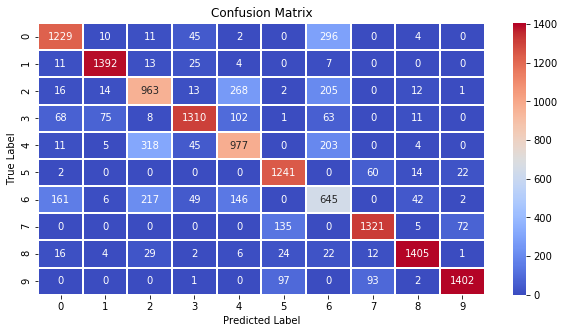

accuracy score: 0.7923333333333333


In [6]:
predictions = lr.predict(testing_set)
plot_confusion_matrix(predictions, testing_label)
print('accuracy score: {}'.format(accuracy_score(predictions, testing_label)))